In [1]:
cd ..

E:\uni\MLiP\git\uncertainty


In [2]:
cd ..

E:\uni\MLiP\git


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, gc
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback

# own imports
from evaluation import Referee, load_data, select_dates, select_day_nums
from train import BatchCreator, Logger
from model_builder import get_pinball_losses, get_simple_dist_model, get_simple_dense_model
from flow import model_predict, denorm_preds, warp_preds_to_ref_form, plot_some, evaluate_model
from preprocess import preprocess, get_features, pandas_cat_data


# Setup file paths
data_dir = 'data/'
os.environ['DATA_DIR'] = data_dir
sub_dir = 'submissions_uncertainty/'

# Hardcode requested quantiles
quantiles = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

# Optimise MLP - level 4

In [4]:
# Load in the data set
calendar, sales_train_validation, sell_prices = load_data()

sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

ref = Referee(sales_true, sales_train, sell_prices, calendar, verbose=True)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
level = 4

model_dir = 'models/uncertainty/hyper_opt/level_{}/'.format(level)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

## Read data

In [6]:
if level <= 9:
    fn = data_dir + 'prep/level_{}_simple_fe_2011_01_29_2016_04_24_normalised_demand.pickle'.format(level)
else:
    fn = data_dir + 'prep/level_{}_simple_fe_2014_04_26_2016_04_24_normalised_demand.pickle'.format(level)

# check if already preprocessed
if os.path.exists(fn):
    data = pd.read_pickle(fn)
else:
    # choose number of years to include
    if level <= 9:
        n_years = 6  # all
    else:
        n_years = 2
    
    # preform preprocessing
    data = preprocess(level=level, n_years=n_years, save_prepared_dataset=True, data_dir=data_dir)
    
# set categorical features
data, available_cat_features = pandas_cat_data(data)

# select features
sell_price_features = ('sell_price' in data.columns)
features = get_features(level=level, sell_price_features=sell_price_features)
print(features)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to  0.01 Mb (74.7% reduction)
3 28
Mem. usage decreased to  0.08 Mb (36.9% reduction)
Mem. usage decreased to  0.01 Mb (0.1% reduction)
Mem. usage decreased to 45.67 Mb (41.7% reduction)
Melted sales train validation has 5739 rows and 4 columns
Selecting 6570 rows (114.5%)
Mem. usage decreased to  0.46 Mb (0.0% reduction)
Saving to file..
Finished.
['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'shift_t28', 'shift_t29', 'shift_t30', 'rolling_std_t7', 'rolling_std_t30', 'rolling_std_t60', 'rolling_std_t90', 'rolling_std_t180', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 'rolling_mean_t90', 'rolling_mean_t180', 'rolling_skew_t30', 'rolling_kurt_t30', 

## Setup training

In [7]:
# going to evaluate with the last 28 days
x_train = data[data['date'] <= '2016-03-27']
y_train = x_train['demand']
x_val = data[(data['date'] > '2016-03-27') & (data['date'] <= '2016-04-24')]
y_val = x_val['demand']
test = data[(data['date'] > '2016-04-24')]

In [8]:
x_train.shape

(5655, 40)

In [14]:
def get_generators(batch_size=256):
    labels = ['demand']
    train_batch_creator = BatchCreator(x_train, features, labels, categorical_features=available_cat_features,
                                      batch_size=batch_size)
    val_batch_creator = BatchCreator(x_val, features, labels, shuffle=False, ensure_all_samples=True,
                                     categorical_features=available_cat_features, batch_size=batch_size)
    
    return train_batch_creator, val_batch_creator

# setup for training
train_batch_creator, val_batch_creator = get_generators()

# determine model input shape
x, y = next(train_batch_creator.flow())
INP_SHAPE = x[0].shape

# make losses
losses = get_pinball_losses()

# lazy evaluation of model
def lazy_evaluate_model(model):
    metrics, df = evaluate_model(model, ref, val_batch_creator, calendar, quantiles, data_dir, level)
    return metrics, df

## Dense(64)

In [15]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 177)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11392       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [16]:
logger = Logger(val_batch_creator)

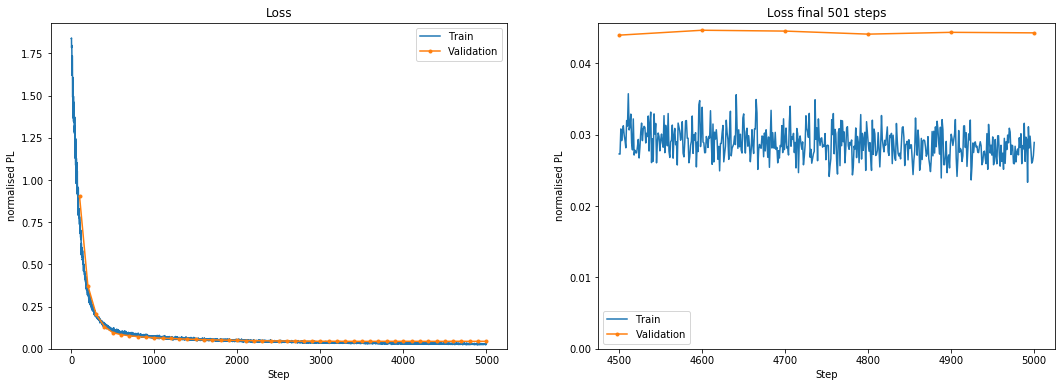

100/100 [==============================] - 3s 28ms/step - loss: 0.0280 - q0_loss: 3.3158e-04 - q1_loss: 0.0011 - q2_loss: 0.0040 - q3_loss: 0.0051 - q4_loss: 0.0063 - q5_loss: 0.0051 - q6_loss: 0.0041 - q7_loss: 0.0015 - q8_loss: 4.6720e-04 - val_loss: 0.0442 - val_q0_loss: 5.2774e-04 - val_q1_loss: 0.0028 - val_q2_loss: 0.0057 - val_q3_loss: 0.0070 - val_q4_loss: 0.0093 - val_q5_loss: 0.0089 - val_q6_loss: 0.0068 - val_q7_loss: 0.0027 - val_q8_loss: 4.9517e-04


In [17]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{4: 0.13290449749741529, 'WSPL': 0.13290449749741529}


IndexError: single positional indexer is out-of-bounds

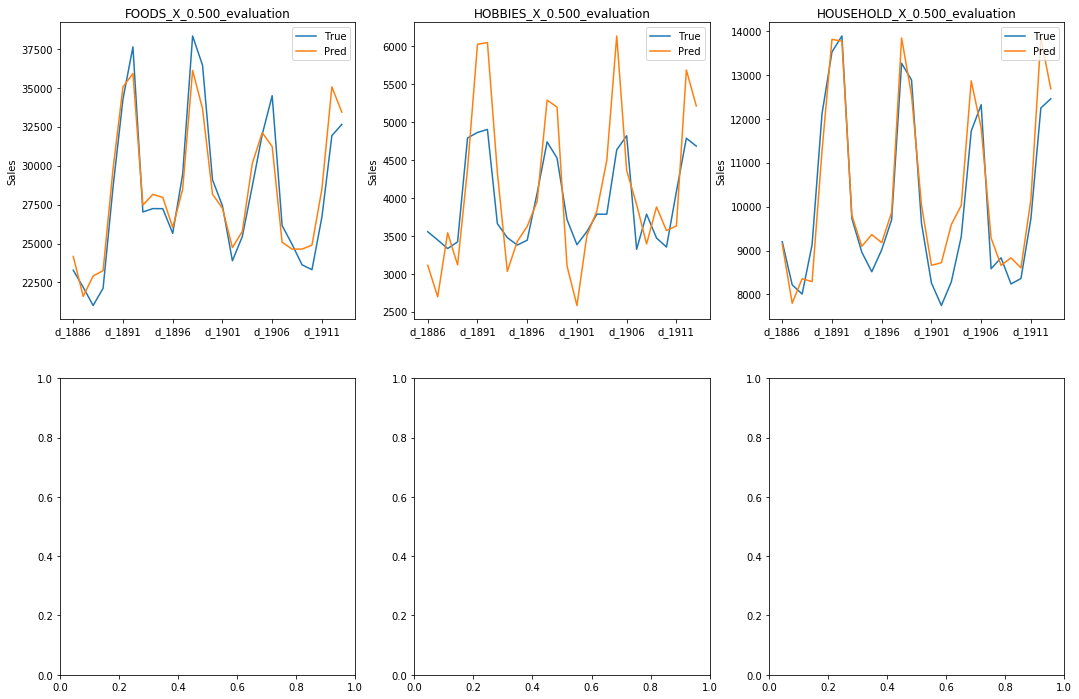

In [13]:
metrics, df = lazy_evaluate_model(model)

In [18]:
model.save(model_dir + "model_batch256_dense64_adamlr1e-4_epochs50_steps100.h5")

## Dense(32)

In [19]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8, num_nodes=32)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 177)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           5696        input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           1056        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
______________________________________________________________________________________________

In [20]:
logger = Logger(val_batch_creator)

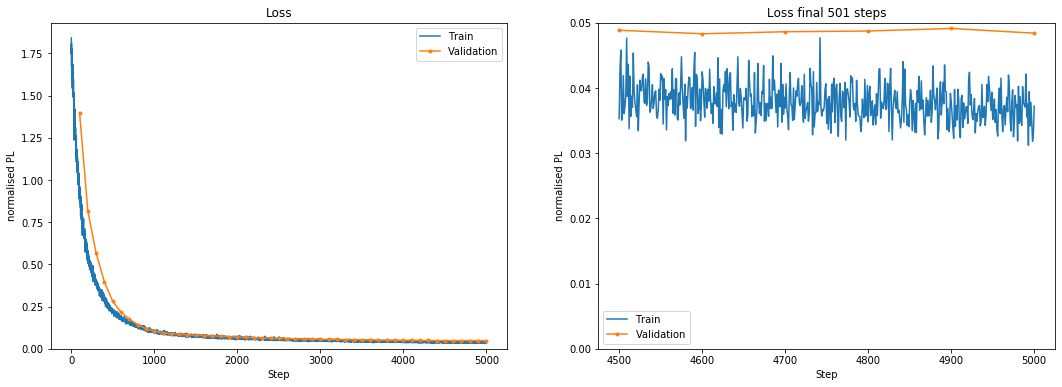

100/100 [==============================] - 3s 29ms/step - loss: 0.0367 - q0_loss: 6.5314e-04 - q1_loss: 0.0015 - q2_loss: 0.0052 - q3_loss: 0.0066 - q4_loss: 0.0081 - q5_loss: 0.0065 - q6_loss: 0.0053 - q7_loss: 0.0018 - q8_loss: 9.7376e-04 - val_loss: 0.0484 - val_q0_loss: 5.6004e-04 - val_q1_loss: 0.0016 - val_q2_loss: 0.0079 - val_q3_loss: 0.0092 - val_q4_loss: 0.0110 - val_q5_loss: 0.0084 - val_q6_loss: 0.0068 - val_q7_loss: 0.0017 - val_q8_loss: 0.0012


In [21]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{4: 0.10241621694320431, 'WSPL': 0.10241621694320431}


IndexError: single positional indexer is out-of-bounds

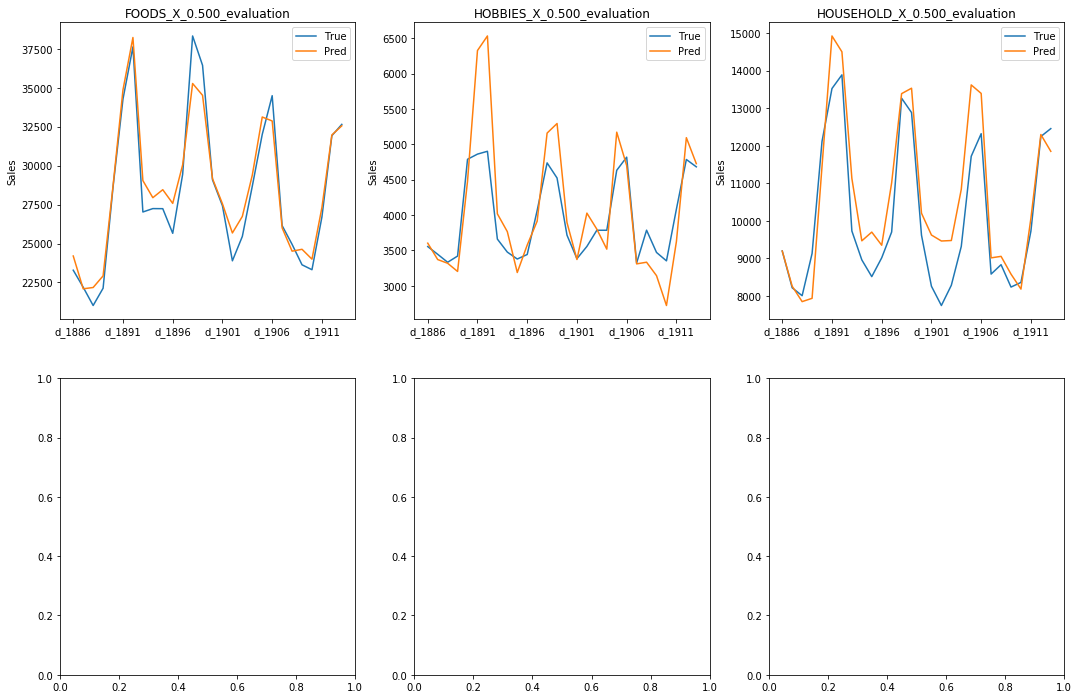

In [22]:
metrics, df = lazy_evaluate_model(model)

In [28]:
model.save(model_dir + "model_batch256_dense32_adamlr1e-4_epochs50_steps100.h5")

## Dense(16)

In [29]:
model = get_simple_dense_model(inp_shape=INP_SHAPE, bottleneck_nodes=8, num_nodes=16)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 177)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16)           2848        input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           272         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 16)           272         dense_1[0][0]                    
______________________________________________________________________________________________

In [30]:
logger = Logger(val_batch_creator)

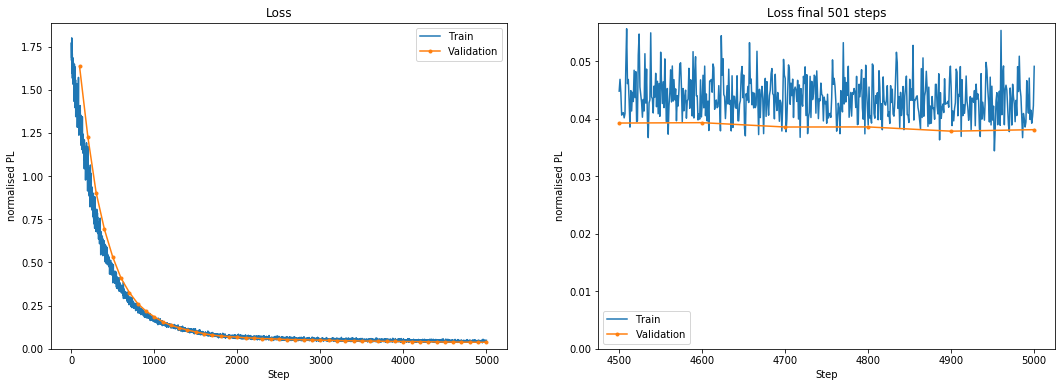

100/100 [==============================] - 3s 30ms/step - loss: 0.0428 - q0_loss: 6.6339e-04 - q1_loss: 0.0019 - q2_loss: 0.0061 - q3_loss: 0.0076 - q4_loss: 0.0095 - q5_loss: 0.0080 - q6_loss: 0.0064 - q7_loss: 0.0020 - q8_loss: 6.4947e-04 - val_loss: 0.0381 - val_q0_loss: 4.4284e-04 - val_q1_loss: 0.0017 - val_q2_loss: 0.0056 - val_q3_loss: 0.0069 - val_q4_loss: 0.0088 - val_q5_loss: 0.0069 - val_q6_loss: 0.0057 - val_q7_loss: 0.0014 - val_q8_loss: 6.5313e-04


In [31]:
# NOTE: Set steps/epoch to 100 to evaluate more often
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{4: 0.08057179803228767, 'WSPL': 0.08057179803228767}


IndexError: single positional indexer is out-of-bounds

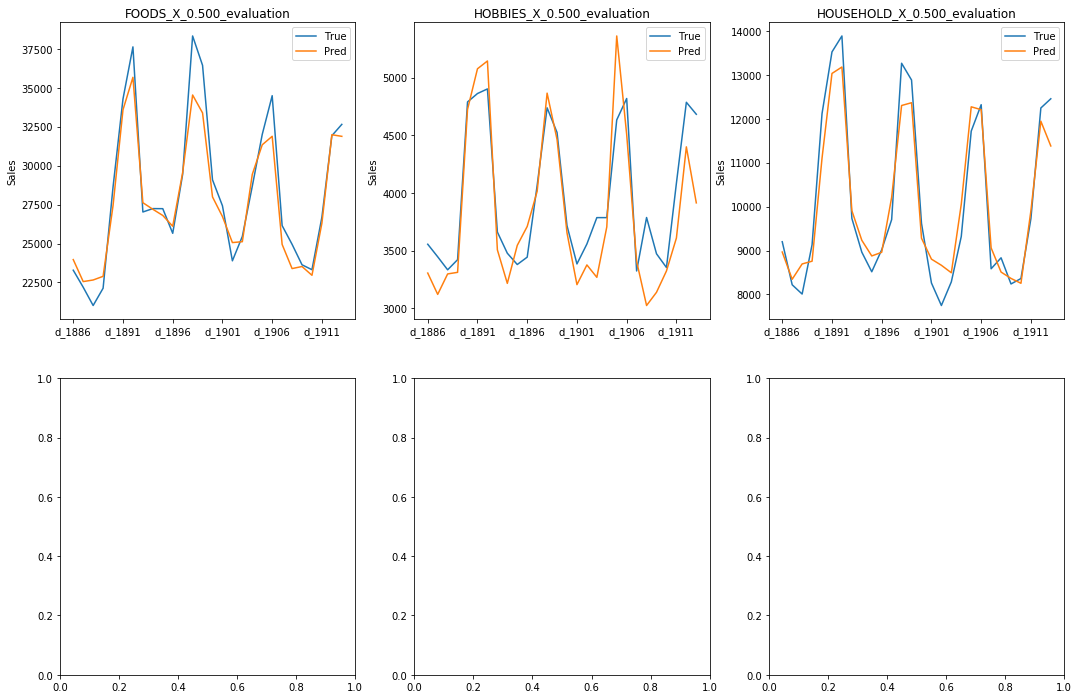

In [32]:
metrics, df = lazy_evaluate_model(model)

In [33]:
model.save(model_dir + "model_batch256_dense16_adamlr1e-4_epochs50_steps100.h5")

### Train dist model

In [34]:
model = get_simple_dist_model(inp_shape=INP_SHAPE)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 177)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           11392       input[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

In [35]:
logger = Logger(val_batch_creator)

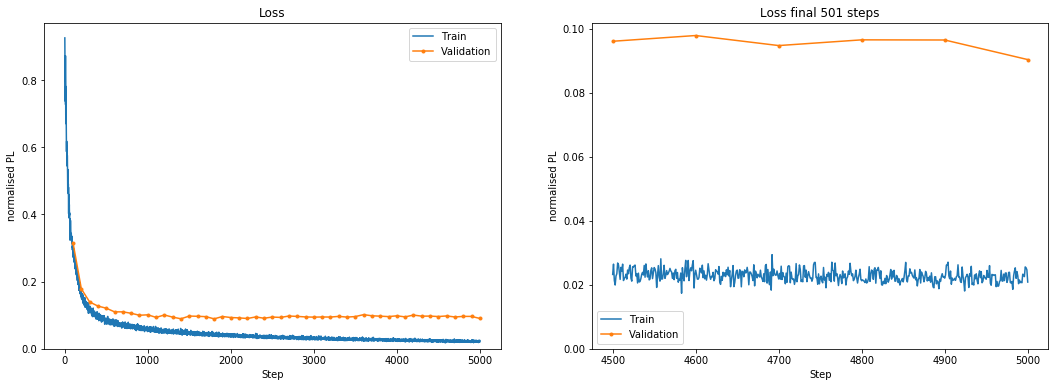

100/100 [==============================] - 3s 32ms/step - loss: 0.0223 - q0_loss: 2.8081e-04 - q1_loss: 8.6800e-04 - q2_loss: 0.0032 - q3_loss: 0.0041 - q4_loss: 0.0052 - q5_loss: 0.0042 - q6_loss: 0.0033 - q7_loss: 9.1135e-04 - q8_loss: 3.1806e-04 - val_loss: 0.0903 - val_q0_loss: 7.0433e-04 - val_q1_loss: 0.0018 - val_q2_loss: 0.0079 - val_q3_loss: 0.0105 - val_q4_loss: 0.0154 - val_q5_loss: 0.0166 - val_q6_loss: 0.0160 - val_q7_loss: 0.0117 - val_q8_loss: 0.0096


In [36]:
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{4: 0.19117208872484315, 'WSPL': 0.19117208872484315}


IndexError: single positional indexer is out-of-bounds

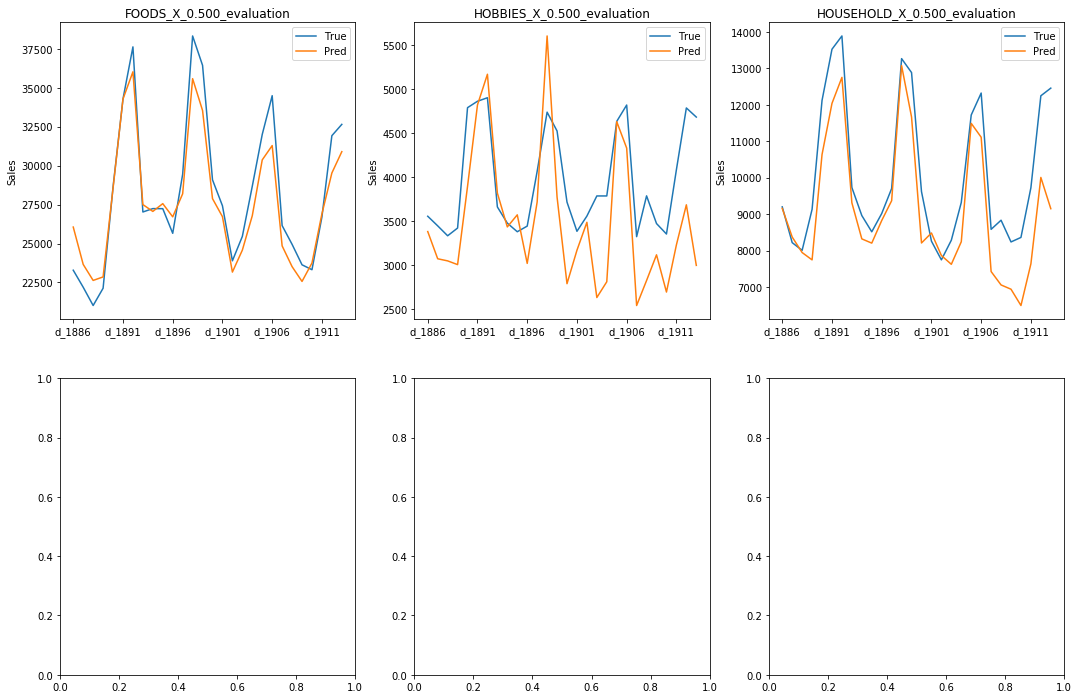

In [37]:
metrics, df = lazy_evaluate_model(model)

In [38]:
model.save(model_dir + "model_batch256_dist64_adamlr1e-4_epochs50_steps100.h5")

### Dist(32)

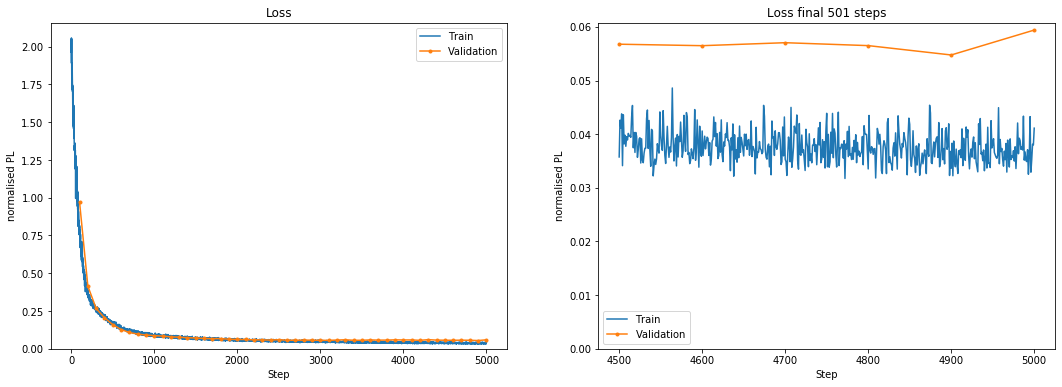

100/100 [==============================] - 3s 29ms/step - loss: 0.0369 - q0_loss: 3.6922e-04 - q1_loss: 0.0013 - q2_loss: 0.0053 - q3_loss: 0.0067 - q4_loss: 0.0085 - q5_loss: 0.0070 - q6_loss: 0.0056 - q7_loss: 0.0016 - q8_loss: 5.5859e-04 - val_loss: 0.0594 - val_q0_loss: 6.0013e-04 - val_q1_loss: 0.0019 - val_q2_loss: 0.0066 - val_q3_loss: 0.0084 - val_q4_loss: 0.0114 - val_q5_loss: 0.0113 - val_q6_loss: 0.0102 - val_q7_loss: 0.0054 - val_q8_loss: 0.0036


In [39]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=32)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{4: 0.1256285986297699, 'WSPL': 0.1256285986297699}


IndexError: single positional indexer is out-of-bounds

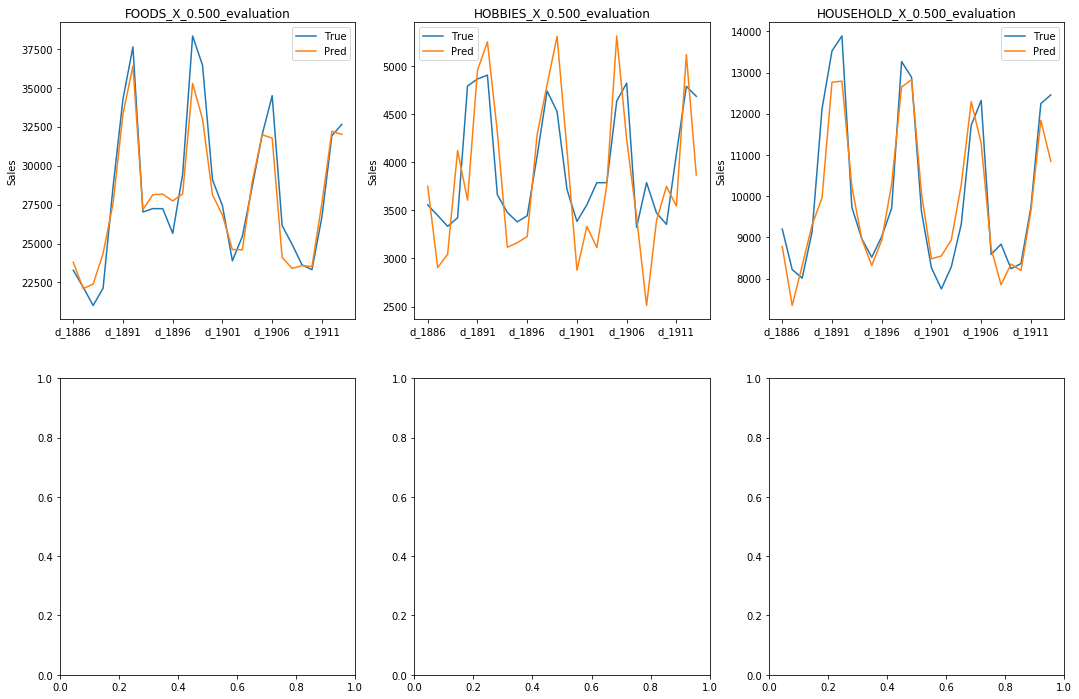

In [40]:
metrics, df = lazy_evaluate_model(model)

In [41]:
model.save(model_dir + "model_batch256_dist32_adamlr1e-4_epochs50_steps100.h5")

### Dist(16)

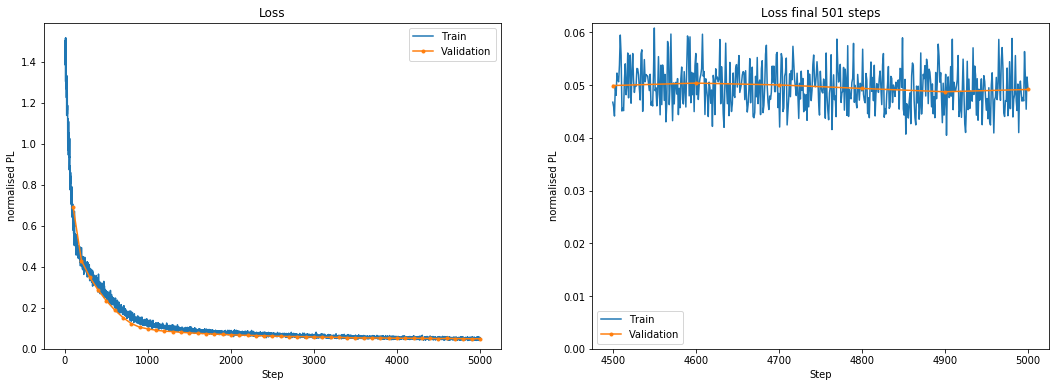

100/100 [==============================] - 3s 30ms/step - loss: 0.0487 - q0_loss: 0.0011 - q1_loss: 0.0023 - q2_loss: 0.0069 - q3_loss: 0.0084 - q4_loss: 0.0102 - q5_loss: 0.0086 - q6_loss: 0.0072 - q7_loss: 0.0026 - q8_loss: 0.0014 - val_loss: 0.0492 - val_q0_loss: 5.1241e-04 - val_q1_loss: 0.0019 - val_q2_loss: 0.0076 - val_q3_loss: 0.0092 - val_q4_loss: 0.0110 - val_q5_loss: 0.0092 - val_q6_loss: 0.0073 - val_q7_loss: 0.0019 - val_q8_loss: 4.5669e-04


In [42]:
# setup
model = get_simple_dist_model(inp_shape=INP_SHAPE, num_nodes=16)
model.compile(optimizer=Adam(learning_rate=1e-4), loss=losses)
logger = Logger(val_batch_creator)

# train
history = model.fit(train_batch_creator.flow(), epochs=50, steps_per_epoch=100,
                    validation_data=val_batch_creator.flow(), validation_steps=val_batch_creator.__len__(),
                    callbacks=[logger])

Predicting...
Denormalising...
Warping predictions...
Evaluating..
{4: 0.10393835854478076, 'WSPL': 0.10393835854478076}


IndexError: single positional indexer is out-of-bounds

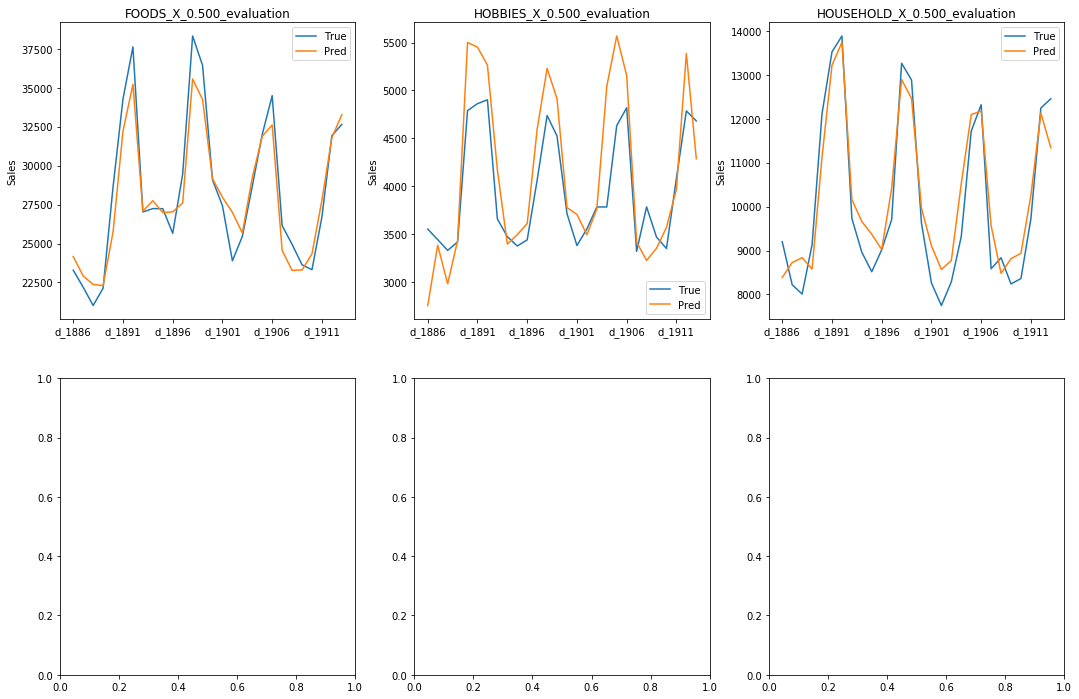

In [43]:
metrics, df = lazy_evaluate_model(model)

In [44]:
model.save(model_dir + "model_batch256_dist16_adamlr1e-4_epochs50_steps100.h5")